Predicting Stock Prices using LSTM, XGBoost, GRU, and ARIMA models

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Run Model -> py LSTMUpdated.py

# Import excel data file of stock prices

data = pd.read_excel('BABATraining2024Updated.xlsx')

print(data.head())



# Activation function -> relu
# Optimizer -> adam
# Loss function -> mean_squared_error
# Epochs  -> 50 to 80 to 100 (Currently 100)
# Batch size -> 32
# Number of LSTM units (neurons) -> 50
# Sequence length -> 50
# Number of Features -> 4 (closing price, daily percentage return, 14 Day Moving RSI, 10 Day Rolling SD/Volatility)



# Normalization Of Stock Price

reshaped_features = data[['Close', 'Daily % Return', '14 Day RSI', '10 Day Rolling SD']].values.reshape(-1, 4)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(reshaped_features)

# Create Sequences As Input For LSTM 
# Number Of Sequences -> Training Data - Sequence Length -> 154 - 50 = 104
# Sequence Length -> 50 
# 154 data points in total (each sequence has 50 data points, from 0 to 49, 1 to 50, .... 104 to 154)


def create_sequences(data, seq_length=50):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length]) # Takes data from position i to i + seq_length - 1 (excludes i + seq_length)
        y.append(data[i+seq_length, 0]) # Takes data from only position i + seq_length onwards (data in x supposed to predict this value)
    return np.array(x), np.array(y).reshape(-1, 1)

SEQ_LENGTH = 50
FEATURE_LENGTH = 4
x, y = create_sequences(scaled_data, SEQ_LENGTH)

print(x.shape)  # Should be (104, 50, 4)
print(y.shape)  # Should be (104, 1), only need close prices

# 1. Define the model architecture
model = tf.keras.Sequential()  # Initialize a linear stack of layers

# 2. Add an LSTM layer
#    - 50 units (neurons)
#    - input_shape: (timesteps=50, features=4)
#    - activation: 'relu' - helps the model learn complex/non-linear patterns, used currently is ReLU (Rectified Linear Unit), which outputs the input value if it's > 0, else (input is 0 or < 0) outputs 0
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, FEATURE_LENGTH)))

# 3. Add a Dense output layer with 1 unit (regression output)
model.add(tf.keras.layers.Dense(1))

# 4. Compile the model
#    - Optimizer: 'adam' - popular gradient-based optimization algorithm
#    - Loss: 'mean_squared_error' - suitable for regression tasks, penalizes larger errors more heavily, most common loss functions for LSTM models used for stock forecasting
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Summary of the model to see number of parameters
model.summary()

# 6. Assume X_train and y_train are your training data prepared as:
#    - X_train shape: (sequences = 104, 50 timesteps, 4 features) -> filter shape using array indexing x[num_samples to keep, timesteps to keep, num_features to keep]
#    - y_train shape: (sequences = 104, 4)


# Train LSTM Model

# Increased epochs from 50 to 80 to 100 after seeing that the model was underfitting (not learning enough from the data)
# After doing so, model's predictions were more consistent with the general trends of the actual stock prices
model.fit(x, y, epochs=80, batch_size=32)

# 7. Plot Predictions Vs Actual

predictions = model.predict(x)

# Inverse scale (reverse transformation) back to original price range

# Helper Function to inverse transform predicted prices, since our original scaler transformed 4 features, inverse transforming expects 4 features

# Need to add dummy features to match the scaler's expected input shape

def inverse_transform_adjusted(actual_data, dummy_data):
    # Actual data only has 1 column/feature
    # Dummy data has 4 columns/features
    a = dummy_data.copy() # Copy dummy data to preserve structure
    a[:, 0:1] = actual_data # Add actual data into the first column of a
    return scaler.inverse_transform(a)[:, 0] # Inverse transform and return only the first column

predicted_prices = inverse_transform_adjusted(predictions, x[:, -1, :]) # x[:, -1, :] -> 3D array indexing -> keeps all samples, only takes the sequence at the last timestep, keeps all the features
actual_prices = inverse_transform_adjusted(y, x[:, -1, :])

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Alibaba Closing Price Prediction (Training Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# Test Data Preparation (Normalization, Creating Sequences, etc) & Predictions

test_data = pd.read_excel('BABATesting2024Updated.xlsx')
reshaped_features_test = test_data[['Close', 'Daily % Return', '14 Day RSI', '10 Day Rolling SD']].values.reshape(-1, 4)
scaled_test_data = scaler.transform(reshaped_features_test)
combined = np.concatenate([scaled_data[-SEQ_LENGTH:], scaled_test_data])
x_test, y_test = create_sequences(combined, SEQ_LENGTH)
predictions_test_scaled = model.predict(x_test)
predicted_prices_test = inverse_transform_adjusted(predictions_test_scaled, x_test[:, -1, :])
actual_prices_test = inverse_transform_adjusted(y_test, x_test[:, -1, :])

# Save predicted and actual prices to Excel for plotting ensemble results

np.savetxt("LSTMPredictedPricesTest.csv", predicted_prices_test, delimiter=",")
np.savetxt("LSTMActualPricesTest.csv", actual_prices_test, delimiter=",")


plt.figure(figsize=(12,6))
plt.plot(actual_prices_test, label='Actual Close Price')
plt.plot(predicted_prices_test, label='Predicted Close Price')
plt.title('Alibaba Closing Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model Evaluation Metrics  (MAE, RMSE (Square Root of Mean Squared Error)))
mae = mean_absolute_error(actual_prices_test, predicted_prices_test)
rmse = np.sqrt(mean_squared_error(actual_prices_test, predicted_prices_test))
print(f"Test MAE: {mae}, Test RMSE: {rmse}")

# Error Metrics Statistics
# Runs
# Test MAE: 9.207184150633143, Test RMSE: 10.838848675670686, loss = 0.0088 (Epochs = 50)
# Test MAE: 6.845713117305021, Test RMSE: 7.755905903865487, loss = 0.0096 (Epochs = 80)
# Test MAE: 6.235186107442201, Test RMSE: 7.847258507073519, loss = 0.0062 (Epochs = 100)
# Test MAE: 10.303890418043396, Test RMSE: 12.650573356448968, loss = 0.0080 (Epochs = 100)
# Test MAE: 5.560828235768788, Test RMSE: 7.312486366211488, loss = 0.0074 (Epochs = 80)


# Test MAE and RMSE ranges from 5 to 10, whilst loss is usually about 0.007 to 0.010
# Observing test set graphs, the model seems to perform better with increased epochs

# 8. Save the trained model after training
model.save('LSTMmodelupdated.keras')





<img src="LSTM Prediction Results/BABA LSTM Prediction Results (2 January 2026 - Test Set 3).png">

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Run Model -> py GRUUpdated.py



# Import excel data file of stock prices

data = pd.read_excel('BABATraining2024Updated.xlsx')



print(data.head())


# Activation function -> relu
# Optimizer -> adam
# Loss function -> mean_squared_error
# Epochs -> 50 to 80 to 100
# Batch size -> 32
# Number of GRU units (neurons) -> 50
# Sequence length -> 50
# Number of Features -> 4 (closing price, daily percentage return, 14 Day Moving RSI, 10 Day Rolling SD/Volatility)



# Normalization Of Stock Price


reshaped_features = data[['Close', 'Daily % Return', '14 Day RSI', '10 Day Rolling SD']].values.reshape(-1, 4)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(reshaped_features)

# Create Sequences As Input For GRU
# Number Of Sequences -> Training Data - Sequence Length -> 154 - 50 = 104
# Sequence Length -> 50 
# 154 data points in total (each sequence has 50 data points, from 0 to 49, 1 to 50, .... 104 to 154)
# Sliding window approach


def create_sequences(data, seq_length=50):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length]) # Takes data from position i to i + seq_length - 1 (excludes i + seq_length)
        y.append(data[i+seq_length, 0]) # Takes data from only position i + seq_length (data in x supposed to predict this value)
    return np.array(x), np.array(y).reshape(-1, 1)

SEQ_LENGTH = 50
FEATURE_LENGTH = 4
x, y = create_sequences(scaled_data, SEQ_LENGTH)

print(x.shape)  # Should be (104, 50, 4)
print(y.shape)  # Should be (104, 1), only need close prices

# 1. Define the model architecture
model = tf.keras.Sequential()  # Initialize a linear stack of layers

# 2. Add a GRU layer
#    - 50 units (neurons)
#    - input_shape: (timesteps=50, features=4)
#    - activation: 'relu' - helps the model learn complex/non-linear patterns, used currently is ReLU (Rectified Linear Unit), which outputs the input value if it's > 0, else (input is 0 or < 0) outputs 0
model.add(tf.keras.layers.GRU(50, activation='relu', input_shape=(SEQ_LENGTH, FEATURE_LENGTH)))

# 3. Add a Dense output layer with 1 unit (regression output)
model.add(tf.keras.layers.Dense(1))

# 4. Compile the model
#    - Optimizer: 'adam' - popular gradient-based optimization algorithm
#    - Loss: 'mean_squared_error' - suitable for regression tasks, penalizes larger errors more heavily, most common loss functions for GRU models used for stock forecasting
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Summary of the model to see number of parameters
model.summary()

# 6. Assume X_train and y_train are your training data prepared as:
#    - X_train shape: (sequences = 104, 50 timesteps, 4 features)
#    - y_train shape: (sequences = 104, 1)


# Train GRU Model

model.fit(x, y, epochs=50, batch_size=32)

# 7. Plot Predictions Vs Actual

predictions = model.predict(x)

# Inverse scale (reverse transformation) back to original price range

# Helper Function to inverse transform predicted prices, since our original scaler transformed 4 features, inverse transforming expects 4 features

# Need to add dummy features to match the scaler's expected input shape

def inverse_transform_adjusted(actual_data, dummy_data):
    # Actual data only has 1 column/feature
    # Dummy data has 4 columns/features
    a = dummy_data.copy() # Copy dummy data to preserve structure
    a[:, 0:1] = actual_data # Add actual data into the first column of a
    return scaler.inverse_transform(a)[:, 0] # Inverse transform and return only the first column



predicted_prices = inverse_transform_adjusted(predictions, x[:, -1, :])
actual_prices = inverse_transform_adjusted(y, x[:, -1, :])


plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Alibaba Closing Price Prediction (Training Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# Test Data Preparation (Normalization, Creating Sequences, etc) & Predictions

test_data = pd.read_excel('BABATesting2024Updated.xlsx')
reshaped_features_test = test_data[['Close', 'Daily % Return', '14 Day RSI', '10 Day Rolling SD']].values.reshape(-1, 4)
scaled_test_data = scaler.transform(reshaped_features_test)
combined = np.concatenate([scaled_data[-SEQ_LENGTH:], scaled_test_data])
x_test, y_test = create_sequences(combined, SEQ_LENGTH)
predictions_test_scaled = model.predict(x_test)
predicted_prices_test = inverse_transform_adjusted(predictions_test_scaled, x_test[:, -1, :])
actual_prices_test = inverse_transform_adjusted(y_test, x_test[:, -1, :])

# Save predicted and actual prices to Excel for plotting ensemble results

np.savetxt("GRUPredictedPricesTest.csv", predicted_prices_test, delimiter=",")
np.savetxt("GRUActualPricesTest.csv", actual_prices_test, delimiter=",")

plt.figure(figsize=(12,6))
plt.plot(actual_prices_test, label='Actual Close Price')
plt.plot(predicted_prices_test, label='Predicted Close Price')
plt.title('Alibaba Closing Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model Evaluation Metrics  (MAE, RMSE (Square Root of Mean Squared Error)))
mae = mean_absolute_error(actual_prices_test, predicted_prices_test)
rmse = np.sqrt(mean_squared_error(actual_prices_test, predicted_prices_test))
print(f"Test MAE: {mae}, Test RMSE: {rmse}")

# Error Metrics Statistics
# Runs
# Test MAE: 4.123330901574646, Test RMSE: 5.396890022922163, loss = 0.0096 (Epochs = 50)
# Test MAE: 6.399352401125365, Test RMSE: 7.848402366854173, loss = 0.0104 (Epochs = 80)
# Test MAE: 8.426736286453327, Test RMSE: 10.069387026391865, loss = 0.0060 (Epochs = 100)
# Test MAE: 6.905943098976501, Test RMSE: 8.439648412212726, loss = 0.0075 (Epochs = 80)

# On average, the model's predictions are off by around $4 to $10 from the actual stock prices in the test set
# Model's predictions, as observed from the graph, are able to capture the general trend of the stock prices well
# It appears the increasing the epochs for the GRU model reduced its accuracy, possibly due to overfitting
# For this specific GRU setup and BABA dataset, around 50 epochs gave the best test MAE/RMSE; increasing to 80 or 100 epochs hurt test performance, which is consistent with overfitting on this dataset.

# 8. Save the trained model after training
model.save('GRUmodelupdated.keras')


<img src="GRU Prediction Results/BABA GRU Prediction Results (2 January 2026 - Test Set 2).png">

                 Date  Close
0 2024-01-02 16:00:00  74.76
1 2024-01-03 16:00:00  76.59
2 2024-01-04 16:00:00  74.66
3 2024-01-05 16:00:00  73.01
4 2024-01-08 16:00:00  72.88
(158, 10)
(158, 1)


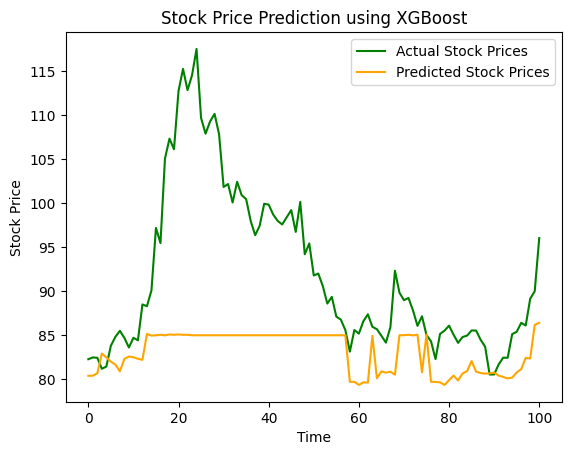

Test MAE: 8.810398746905943, Test RMSE: 11.841191943860768


In [5]:
import gradio as gr
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt # Package to plot graphs
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb;

# Run Model -> py XGBoostgeneral.py

# Import excel data file of stock prices

trainingdata = pd.read_excel('BABATraining2024.xlsx')
testdata = pd.read_excel('BABATesting2024.xlsx')

print(trainingdata.head())

# Normalization Of Stock Price (Training Data)

close_prices = trainingdata['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# The XGBoost model is currently using a lag-based forecasting method, where to predict a price at time T, the model requires the "lag" / 10 number of previous data points (price at T-1, T-2, T-3, T-4 ..... etc)

def create_lags(data, n_lags=10):
    x, y = [], []
    for i in range(n_lags, len(data)):
        x.append(data[i-n_lags:i].flatten())  # Past n_lags as flat features
        y.append(data[i])
    return np.array(x), np.array(y)

x, y = create_lags(scaled_data, n_lags=10)

print(x.shape)  # (158, 10)
print(y.shape)  # (158, 1)

# Normalization Of Stock Price (Test Data)

close_prices_test = testdata['Close'].values.reshape(-1, 1)
scaled_test_data = scaler.transform(close_prices_test)

combined_data = np.concatenate([scaled_data[-10:], scaled_test_data])
x_test, y_test = create_lags(combined_data, n_lags=10)

# keep only lags that belong to test part

x_test = x_test[-len(scaled_test_data):]
y_test = y_test[-len(scaled_test_data):]

# Run the XGBoost model

model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

model.fit(x, y.ravel())

predictions = model.predict(x_test)

predictions_reshaped = predictions.reshape(-1, 1)

predicted_prices = scaler.inverse_transform(predictions_reshaped)

actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(actual_prices, color = 'green', label = 'Actual Stock Prices')

plt.plot(predicted_prices, color = 'orange', label = 'Predicted Stock Prices')

plt.title('Stock Price Prediction using XGBoost')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Model Evaluation Metrics  (MAE, RMSE (Square Root of Mean Squared Error)))
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Test MAE: {mae}, Test RMSE: {rmse}")

# Error Metrics Statistics
# Runs
# Test MAE: 8.810398746905943, Test RMSE: 11.841191943860768

# Save the trained model after training
model.save_model('XGBoostmodel.json')



# Results 
# On average, predicted price differs from actual prices by $8 to $11
# Predictions at time 20 to 60 are significantly lower than actual prices
# The XGBoost model may not have been able to predict the sudden increase in price at time ~ 20 from the lagging prices (10 previous price points) alone
# There could have been other factors that could not have been encoded in the previous 10 price points (e.g. earnings report release, macro events, etc)
# ML models in general are biased towards minimizing loss functions, so if the previous data shows minor changes in prices, the model will choose to predict minor changes in prices



In [ ]:
# ARIMA Model

import gradio as gr
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt # Package to plot graphs
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Run Model -> py ARIMAgeneral.py

# Import excel data file of stock prices

trainingdata = pd.read_excel('BABATraining2024.xlsx', parse_dates= ['Date'])
testdata = pd.read_excel('BABATesting2024.xlsx', parse_dates = ['Date'])

print(trainingdata.head())

# Convert data into a time series format

trainingdatatimeseries = trainingdata.set_index('Date')['Close']
testdatatimeseries = testdata.set_index('Date')['Close']

# Train and fit the ARIMA model

model = ARIMA(trainingdatatimeseries, order = (1,1,1)) 
# Order contains p (number of lag observations to add to prediction), d (number of differencing needed), and q (number of lagged forecast errors to add to a prediction)
# Arbitrarily defined, need to find the optimal combination of these values to maximize accuracy

fittedmodel = model.fit()

# Do a forecast that goes the same number of time steps as the length of the test data

forecast = fittedmodel.forecast(steps=len(testdatatimeseries))

# Align forecast index with test data index

# aligning the forecast with the test indices ensures that we are always comparing the correct predicted against actual values at a time step t

# There could be situations where the forecast index does not automatically align with the test data index, especially if there are missing dates or different date ranges

forecast.index = testdatatimeseries.index

# Model Evaluation Metrics  (MAE, RMSE (Square Root of Mean Squared Error)))
mae = mean_absolute_error(testdatatimeseries, forecast)
rmse = np.sqrt(mean_squared_error(testdatatimeseries, forecast))
print(f"Test MAE: {mae}, Test RMSE: {rmse}")

# Error Metrics Statistics
# Runs
# Test MAE: 11.855570862741212, Test RMSE: 15.143951976267434

# On this BABA dataset, a simple univariate linear ARIMA on closing prices alone cannot capture the dynamics. 
# As seen in the plotted graph, the predicted prices are very off from the actual prices
# This could be due to the prices having a non linear relationship over time, exacerbated by possibly suboptimal parameters. 
# ARIMA cannot capture non-linear relationships since it is a linear model
# Nonlinear or more flexible models (GRU, LSTM) do better.

# Plot the results

plt.figure(figsize=(12,6))
plt.plot(testdatatimeseries, label='Actual Close Price')
plt.plot(forecast, label='Predicted Close Price')
plt.title('Alibaba Closing Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

<img src="ARIMA Prediction Results/BABA ARIMA Prediction Results (26 December 2025 - Test Set).png">

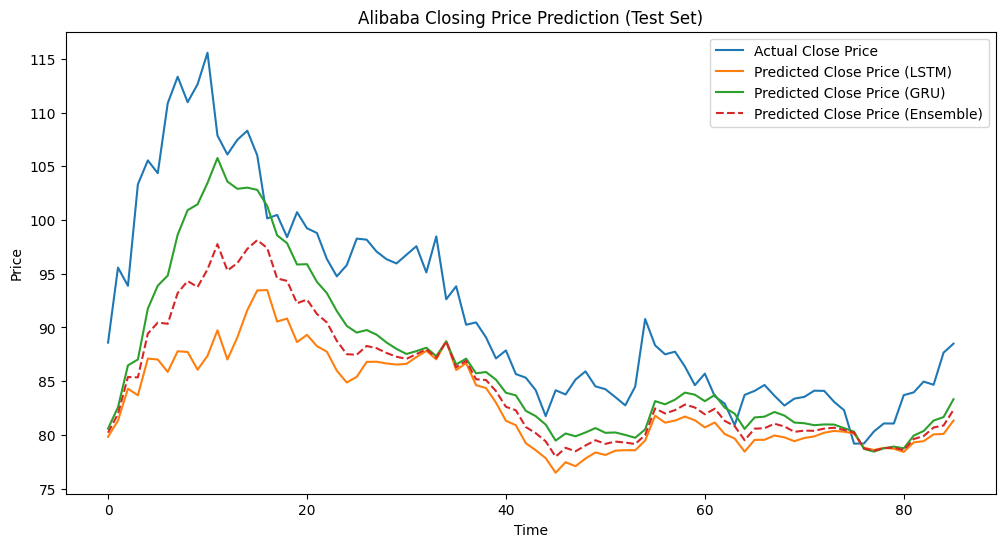

In [7]:
import gradio as gr
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt # Package to plot graphs
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb;

# Run -> py EnsembleResults.py

# Plot ensemble results from multiple models (LSTM, GRU)

# Load predicted prices from the LSTM and GRU models 

predicted_prices_test_LSTM = np.loadtxt("LSTMPredictedPricesTest.csv", delimiter=",")
predicted_prices_test_GRU = np.loadtxt("GRUPredictedPricesTest.csv", delimiter=",")
predicted_prices_test_ensemble = (predicted_prices_test_LSTM + predicted_prices_test_GRU) / 2
actual_prices_test = np.loadtxt("LSTMActualPricesTest.csv", delimiter=",")

# Plot the actual prices, predicted prices, and ensemble (average predicted price of both models)

plt.figure(figsize=(12,6))
plt.plot(actual_prices_test, label='Actual Close Price')
plt.plot(predicted_prices_test_LSTM, label='Predicted Close Price (LSTM)')
plt.plot(predicted_prices_test_GRU, label='Predicted Close Price (GRU)')
plt.plot(predicted_prices_test_ensemble, label='Predicted Close Price (Ensemble)', linestyle='--')
plt.title('Alibaba Closing Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Ensemble Plot Analysis

As seen from the results, both models are still underpredicting prices, but predict general trends well. This is common in LSTM/GRU models which tend to be more conservative regarding upward price movements (negatively biased)

The Ensemble balances out the price fluctuations/variance from both models.

Overall, both models predict price trends well, but their underprediction bias needs to be considered when using them in actual investing